In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 384
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DogEmotions",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1903 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Angry', 'Happy', 'Relaxed', 'Sad']

In [5]:
len(dataset)

60

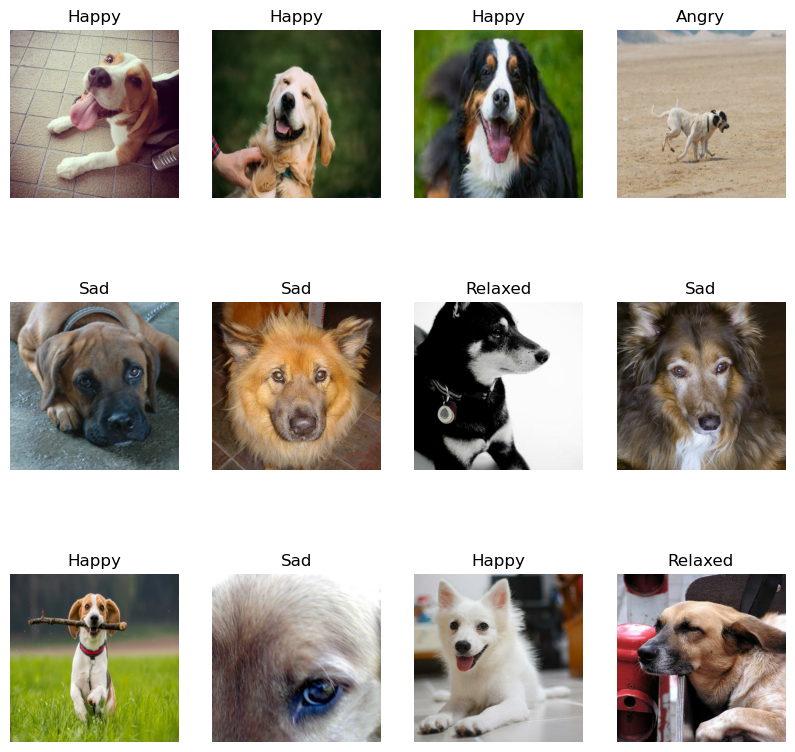

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
#Splitting the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

48

In [10]:
len(test_ds)

6

In [11]:
len(val_ds)

6

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Data Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
# Model building using CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 384, 384, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 384, 384, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 382, 382, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 191, 191, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 189, 189, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 94, 94, 64)         0         
 2D)                                                  

In [17]:
# Compiling the model by using adam optimizer
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/60
48/48 [==============================] - 191s 4s/step - loss: 1.3879 - accuracy: 0.2502 - val_loss: 1.3828 - val_accuracy: 0.2240
Epoch 2/60
48/48 [==============================] - 177s 4s/step - loss: 1.3843 - accuracy: 0.2739 - val_loss: 1.3831 - val_accuracy: 0.2240
Epoch 3/60
48/48 [==============================] - 180s 4s/step - loss: 1.3827 - accuracy: 0.2772 - val_loss: 1.3699 - val_accuracy: 0.3594
Epoch 4/60
48/48 [==============================] - 181s 4s/step - loss: 1.3807 - accuracy: 0.2765 - val_loss: 1.3780 - val_accuracy: 0.2344
Epoch 5/60
48/48 [==============================] - 181s 4s/step - loss: 1.3799 - accuracy: 0.3015 - val_loss: 1.3658 - val_accuracy: 0.3542
Epoch 6/60
48/48 [==============================] - 183s 4s/step - loss: 1.3696 - accuracy: 0.2916 - val_loss: 1.3353 - val_accuracy: 0.3438
Epoch 7/60
48/48 [==============================] - 185s 4s/step - loss: 1.3490 - accuracy: 0.3344 - val_loss: 1.3384 - val_accuracy: 0.3438
Epoch 8/60
48

Epoch 59/60
48/48 [==============================] - 189s 4s/step - loss: 0.8759 - accuracy: 0.6215 - val_loss: 0.9262 - val_accuracy: 0.5990
Epoch 60/60
48/48 [==============================] - 181s 4s/step - loss: 0.8586 - accuracy: 0.6267 - val_loss: 0.9096 - val_accuracy: 0.6042


In [20]:
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 686ms/step


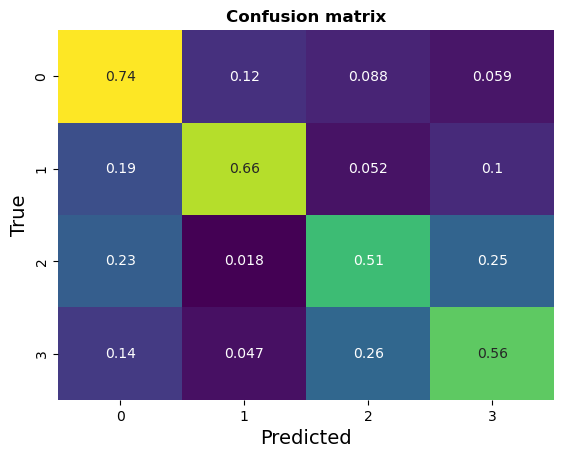

<Figure size 5000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

In [22]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()
plt.figure(figsize=(50,50))

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

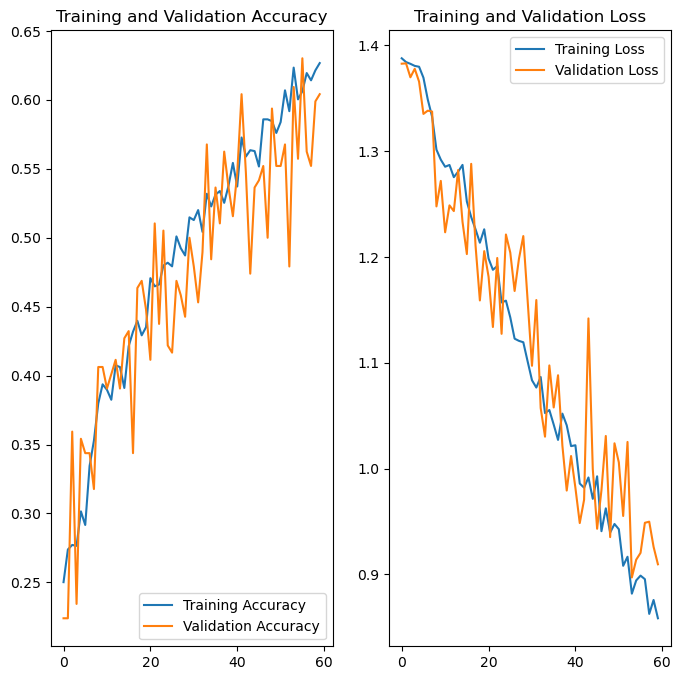

In [24]:
# Training vs Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label : Relaxed
1/1 [==============================] - 1s 723ms/step
Predicted Label : Relaxed


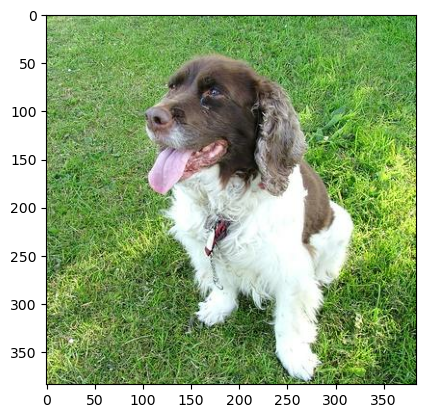

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label :", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label :", class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Creating a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


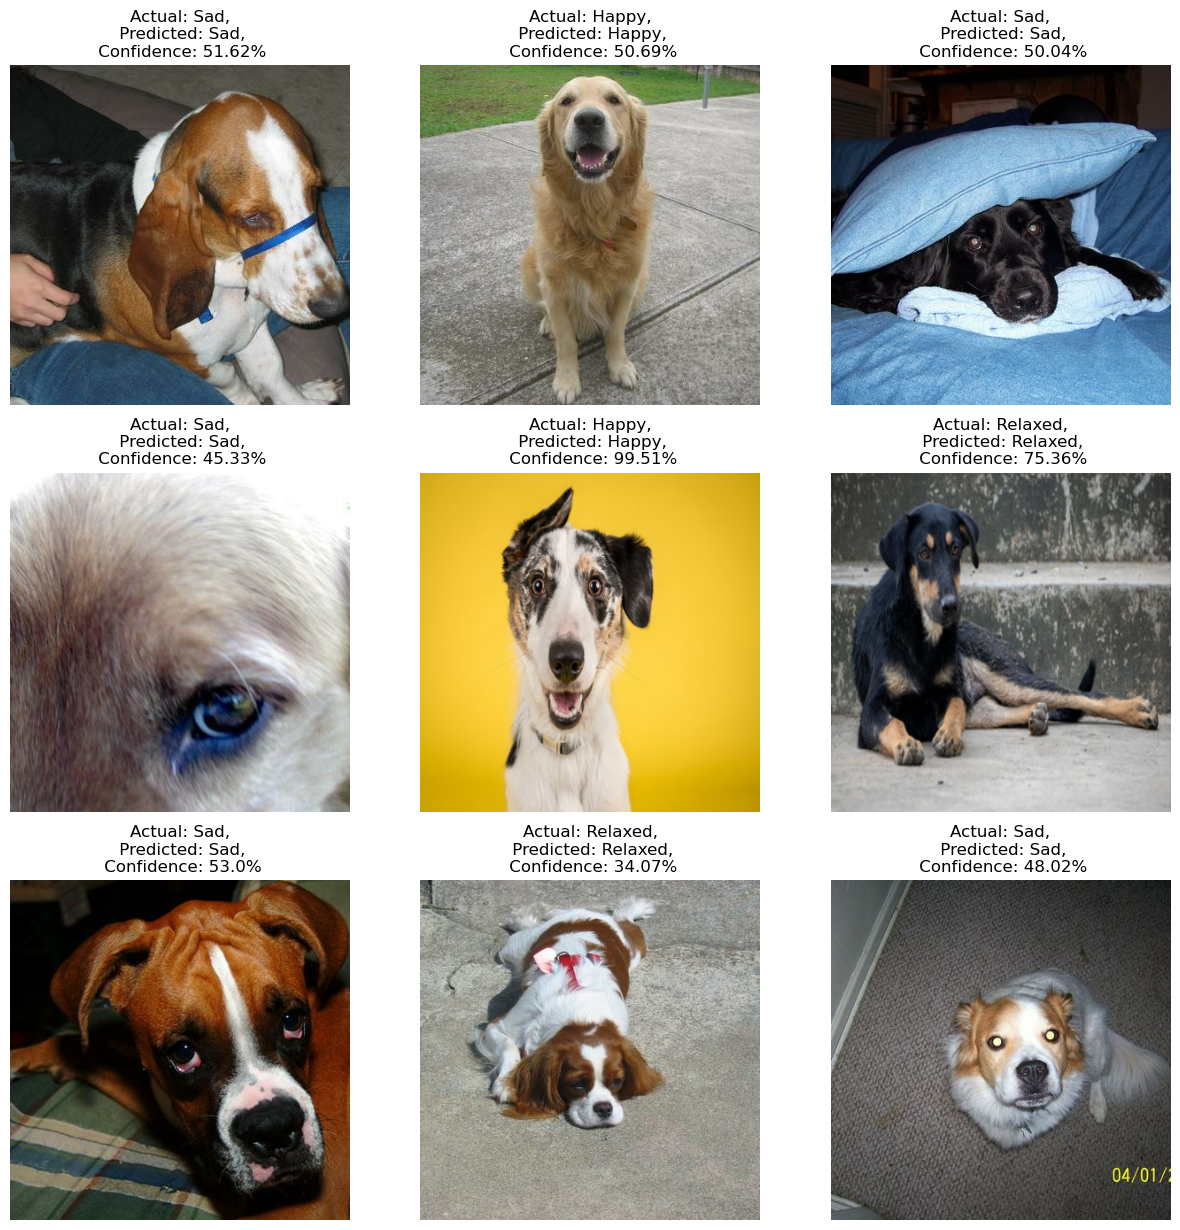

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
